The RDKit stores atomic coordinates in `Conformer` objects which are attached to the corresponding molecules. In this tutorial post we're going to look in detail at the way conformers are stored and ways to work with them.


In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom
import rdkit
print(rdkit.__version__)

2022.09.4


A molecule constructed from SMILES has no conformer information:

In [2]:
esomeprazole = Chem.MolFromSmiles('COc1ccc2[n-]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1')
esomeprazole.GetNumConformers()

0

An aside: when you display a molecule without conformers in Jupyter, a 2D conformer is generated so that there's something to display:

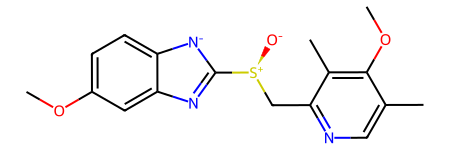

In [3]:
esomeprazole

But this conformer is just temporary; the molecule itself is not modified:

In [4]:
esomeprazole.GetNumConformers()

0

When we ask to have 2D coordinates generated, they are added as a conformer:

In [5]:
rdDepictor.Compute2DCoords(esomeprazole)
esomeprazole.GetNumConformers()

1

And that conformer is flagged as not being 3D:

In [6]:
esomeprazole.GetConformer().Is3D()

False

Generating a 3D structure also results in a conformer being added to the molecule (by default any existing conformers are cleared):

In [7]:
esomeprazole = Chem.AddHs(esomeprazole) # <- add hydrogens so that we get a reasonable conformer
rdDistGeom.EmbedMolecule(esomeprazole)
print(esomeprazole.GetNumConformers(),esomeprazole.GetConformer().Is3D())

1 True


[09:59:21] UFFTYPER: Unrecognized charge state for atom: 8


Molecules can have more than one conformer attached. This is what happens whenever we ask for multiple conformers to be generated:

In [8]:
rdDistGeom.EmbedMultipleConfs(esomeprazole,10, randomSeed=0xf00d) # <- generate 10 conformers
print(esomeprazole.GetNumConformers(),esomeprazole.GetConformer().Is3D())

[09:59:22] UFFTYPER: Unrecognized charge state for atom: 8


10 True


Calling `GetConformer()` without arguments on a molecule with multiple conformers (as we did above) returns the default conformer. This is also what most RDKit operations that work with conformers do:

In [9]:
IPythonConsole.drawMol3D(esomeprazole)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
print(Chem.MolToV3KMolBlock(esomeprazole)[:200])


     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 42 44 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C 7.673833 1.902627 0.749932 0
M  V30 2 O 6.455003 1.586360 1.35


But functions which use conformer information also generally take an optional `confId` argument that allows you to change which conformer is used:

In [11]:
IPythonConsole.drawMol3D(esomeprazole,confId=2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
print(Chem.MolToV3KMolBlock(esomeprazole,confId=2)[:200])


     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 42 44 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C 8.236088 0.676672 -0.133971 0
M  V30 2 O 7.679673 -0.571643 0.


As an aside: the `Is3D` flag on conformers is used by the RDKit's jupyter integration to decide how to show the molecule. We can fool it by marking a 3D conformer as 2D:

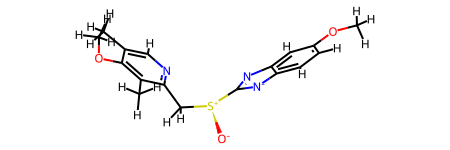

In [14]:
tmol = Chem.Mol(esomeprazole)
tmol.GetConformer().Set3D(False)
tmol

or a 2D conformer as 3D:

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

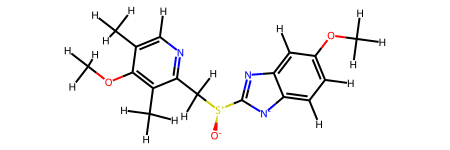

In [15]:
rdDepictor.Compute2DCoords(tmol)
tmol.GetConformer().Set3D(True)
tmol

## Conformer IDs

Each conformer has an ID associated with it:

In [26]:
print([x.GetId() for x in esomeprazole.GetConformers()])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


And there's no guarantee that the IDs are consecutive:

In [28]:
cp = Chem.Mol(esomeprazole)
cp.RemoveConformer(0)
cp.RemoveConformer(3)
cp.RemoveConformer(7)
print([x.GetId() for x in cp.GetConformers()])

[1, 2, 4, 5, 6, 8, 9]


The default conformer is just the first one:

In [30]:
esomeprazole.GetConformer().GetId(),cp.GetConformer().GetId()

(0, 1)

If we ask for a conformer Id which doesn't exist, we get an error

In [33]:
cp.GetConformer(12)

ValueError: Bad Conformer Id

So it's usually better to loop over conformers by using `for conf in m.GetConformers()` than to do something like `for confid in range(m.GetNumConformers())`

## Getting atom positions

We can get the position of an individual atom using the `GetAtomPosition()` method:

In [17]:
conf = esomeprazole.GetConformer()
pos = conf.GetAtomPosition(0)
pos

Point3D objects have x, y, an z members:

In [18]:
pos.x

7.673833423925606

We can also treat them as vectors:

In [19]:
pos[0]

7.673833423925606

or convert them to a list:

In [20]:
list(pos)

[7.673833423925606, 1.9026270201484923, 0.7499323617732389]

If you want to work with all of the atom positions at once, you can get the full set of positions as a numeric python array:

In [36]:
conf = esomeprazole.GetConformer()
conf.GetPositions()

array([[ 7.67383342,  1.90262702,  0.74993236],
       [ 6.45500303,  1.5863599 ,  1.35650536],
       [ 5.47994258,  0.87148768,  0.70572686],
       [ 5.73975972,  0.49700014, -0.60402982],
       [ 4.78365557, -0.22724183, -1.28080521],
       [ 3.59642905, -0.54463893, -0.59986585],
       [ 2.59405829, -1.21382165, -1.03927358],
       [ 1.57249064, -1.34923356, -0.0664238 ],
       [ 0.23760111, -2.18813362, -0.61069031],
       [ 0.81652921, -3.85758446, -0.60953112],
       [-1.27391039, -2.26700639,  0.09012225],
       [-2.10815098, -1.11798724,  0.39836845],
       [-1.98174435, -0.40660263,  1.56568982],
       [-2.94381966,  0.4469877 ,  1.9742195 ],
       [-4.10302205,  0.68692145,  1.27699325],
       [-5.19127878,  1.57733968,  1.7705111 ],
       [-4.26093798, -0.01014656,  0.07490913],
       [-5.42572563,  0.23147474, -0.6552053 ],
       [-5.42087157,  1.29218749, -1.61825447],
       [-3.29351791, -0.86279333, -0.31409244],
       [-3.3729589 , -1.58163605, -1.642

## Adding/removing conformers

I already showed how to remove conformer in the section on conformer IDs, but you can also add conformers to a molecule.

Let's start by getting a conformer which is a canonical orientation: centered at the origin and with its principle axes aligned with the cartesian axes:

In [22]:
from rdkit.Chem import rdMolTransforms

# GetConformer() returns a reference to the existing conformer, we want a copy:
conf = Chem.Conformer(esomeprazole.GetConformer(0))
rdMolTransforms.CanonicalizeConformer(conf)


Make a copy of the molecule and add a 2D conformer, by default Compute2DCoords() clears the existing conformers

In [28]:
cp = Chem.Mol(esomeprazole)
rdDepictor.Compute2DCoords(cp)


0

Now add the that canonical conformer and set its ID so that it is unique. The return value is the new conformer ID


In [29]:
cp.AddConformer(conf,assignId=True)

1

In [32]:
cp.GetConformer().GetPositions()[:3]

array([[8.41075857, 1.90814121, 0.        ],
       [6.92408705, 2.10766008, 0.        ],
       [6.00796287, 0.91992422, 0.        ]])

In [33]:
cp.GetConformer(1).GetPositions()[:3]

array([[ 7.39395019,  1.81765991, -0.52124964],
       [ 6.17231368,  1.90827963,  0.15172549],
       [ 5.15244456,  1.01460864, -0.06395248]])

## Getting a new molecule with just one conformer

There are often times you want to copy a multi-conformer molecule but just keep one of the conformers.

The standard way of copying RDKit molecules will copy all conformers:

In [35]:
cp = Chem.Mol(esomeprazole)
cp.GetNumConformers()

10

But we can tell it to just copy one:

In [38]:
cp = Chem.Mol(esomeprazole,confId=5)
print(cp.GetNumConformers(), cp.GetConformer().GetId())

1 5
